<a href="https://colab.research.google.com/github/ccosmin97/idc-prostate-mri-analysis/blob/main/MONAI_prostate158_cancer_qin_prost_rep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auth login

In [1]:
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np

In [2]:
#colab 
from google.colab import auth
auth.authenticate_user()

In [3]:
project_id = "idc-nlst-unet-seg"
os.environ["GCP_PROJECT_ID"] = project_id

# Env setup

## Install command-line tools


In [4]:
%%capture
!sudo apt update

!sudo apt install plastimatch

In [5]:
!echo $(plastimatch --version)

plastimatch version 1.8.0


[dcmqi](https://github.com/QIICR/dcmqi) is an open source library that can help with the conversion between imaging research formats and the standard DICOM representation for image analysis results. More specifically, you can use dcmqi convert DICOM Segmentation objects (DICOM SEG) into research formats, such as NIfTI and NRRD.

In [6]:
%%capture
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

Finally, we are going to install [Subversion](https://subversion.apache.org/), a tool that will allow us to clone GitHub repositories only partially (to save time and space).

In [7]:
%%capture

!sudo apt install subversion

In [8]:
!echo $(svn --version | head -n 2)

svn, version 1.13.0 (r1867053) compiled May 12 2022, 20:47:08 on x86_64-pc-linux-gnu


## MONAI Prostate cancer environment setup

### Monai setup and imports

In [9]:
%%capture
!pip install simpleitk
!pip install -U "monai[all]" pyyaml munch pandas

In [10]:
%%capture
!sudo apt update
!sudo apt install plastimatch
!sudo apt install subversion
# PyPlastimatch - paython wrapper for Plastimatch (and interactive notebook visualisation)
!svn checkout https://github.com/AIM-Harvard/pyplastimatch/trunk/pyplastimatch pyplastimatch

In [11]:
%%capture
!pip install protobuf==3.9.2
!pip install grpcio
!pip install grpcio-tools
!pip install google-cloud-bigquery
!pip install pydicom
!pip install nibabel
!pip install dcm2niix

In [12]:
%%capture
!pip install 'itkwidgets>=1.0a16'

Imports

In [13]:
from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.utils import viz as viz_utils
from pyplastimatch.utils import data as data_utils
import nibabel as nib
import pandas as pd
import pydicom
import nibabel as nib
from scipy import ndimage
import numpy as np
import glob
import json
import os

Sort dicom data package

In [14]:
# dicomsort is the pythong package that can sort DICOM files into
# folder organization based on user-specified DICOM attributes
!git clone https://github.com/pieper/dicomsort.git

Cloning into 'dicomsort'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 169 (delta 23), reused 34 (delta 17), pack-reused 126
Receiving objects: 100% (169/169), 87.85 KiB | 2.51 MiB/s, done.
Resolving deltas: 100% (86/86), done.


Colab imports

In [15]:
#colab 
from google.colab import auth
auth.authenticate_user()

# QIN Prostate Repeatability -- Data selection -- BigQuery

We select here all T2W, ADC and DWI images within a study that has T2W segmentation objects with lesion segmented

In [16]:
bq_client = bigquery.Client(os.environ["GCP_PROJECT_ID"])
selection_query = f"""
WITH
  dwi_series AS(
  SELECT
    StudyInstanceUID,
    SeriesInstanceUID,
    SOPInstanceUID,
    PatientID,
    Modality,
    collection_id,
    StudyDescription,
    SeriesDescription,
    StudyDate,
    SeriesDate,
    gcs_url,
    (
    SELECT
      SeriesInstanceUID
    FROM
      UNNEST(ReferencedSeriesSequence)) AS RefSerieUID,
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  LEFT JOIN
    UNNEST (OtherElements ) AS oe_unnested
  WHERE
    collection_id = "qin_prostate_repeatability"
    AND SeriesDescription = "DWI"
    AND oe_unnested.Tag = "Tag_00431039"
    AND oe_unnested.Data[
  OFFSET
    (0)] = "1400"),

  
  t2_seg_lesion_series AS (
  SELECT
    DISTINCT(StudyInstanceUID)
  FROM
    `bigquery-public-data.idc_v14.dicom_all` AS dc_all
  CROSS JOIN
    UNNEST(SegmentSequence) AS segSeq
  WHERE
    collection_id = 'qin_prostate_repeatability'
    AND segSeq.SegmentedPropertyTypeCodeSequence[SAFE_OFFSET(0)].CodeMeaning = 'Lesion'
    AND SeriesDescription = 'T2 Weighted Axial Segmentations'),

  adc_t2_dwi_series AS (
  SELECT
    dc_all.StudyInstanceUID,
    dc_all.SeriesInstanceUID,
    dc_all.SOPInstanceUID,
    dc_all.PatientID,
    dc_all.Modality,
    dc_all.collection_id,
    dc_all.StudyDescription,
    dc_all.SeriesDescription,
    dc_all.StudyDate,
    dc_all.SeriesDate,
    dc_all.gcs_url,
    (
    SELECT
      SeriesInstanceUID
    FROM
      UNNEST(dc_all.ReferencedSeriesSequence)) AS RefSerieUID
  FROM
    `bigquery-public-data.idc_v14.dicom_all` as dc_all
  RIGHT JOIN
    t2_seg_lesion_series as lesions
  ON
    dc_all.StudyInstanceUID = lesions.StudyInstanceUID 
  WHERE
    collection_id = 'qin_prostate_repeatability'
    AND SeriesDescription IN ('T2 Weighted Axial',
      'Apparent Diffusion Coefficient',
      'T2 Weighted Axial Segmentations',
      'Apparent Diffusion Coefficient Segmentations'))
SELECT
  *
FROM
  adc_t2_dwi_series
UNION ALL
SELECT
  dwi.*
FROM
  dwi_series as dwi
RIGHT JOIN
    t2_seg_lesion_series as lesions
  ON
    dwi.StudyInstanceUID = lesions.StudyInstanceUID""" 

Lesion data to retrieve as ground-truth

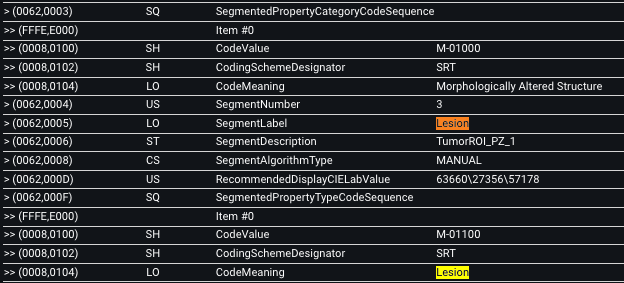

In [17]:
selection_result = bq_client.query(selection_query)
selection_df = selection_result.result().to_dataframe()
#select only one study
selection_df = selection_df[selection_df.StudyInstanceUID \
                            == selection_df.StudyInstanceUID.values[0]]

In [18]:
len(selection_df.StudyInstanceUID.unique())

1

## Download

In [19]:
!rm -rf idc_downloads
!mkdir -p idc_downloads
#
!rm -rf idc_downloads_sorted
!mkdir -p idc_downloads_sorted

In [20]:
# save the list of GCS URLs into a file
selection_manifest = os.path.join("idc_downloads", "idc_manifest.txt")
selection_df["gcs_url"].to_csv(selection_manifest, header=False, index=False)

In [21]:
# confirm the resulting manifest has as many lines as the number of rows in the
# dataframe we initialized earlier
!cat {selection_manifest} |wc

     78      78    8034


In [22]:
# let's make sure the download folder is clean, in case you ran this cell earlier
# for a different dataset
!rm -rf {"idc_downloads"+"/*.dcm"}

print(selection_manifest)

idc_downloads/idc_manifest.txt


In [23]:
# download is this simple!
%%capture
!cat {selection_manifest} | gsutil -m cp -I idc_downloads/

To facilitate preparation of the data, we will sort the downloaded files into the PatientID/StudyInstanceUID/SeriesInstanceUID hierarchy.

In [24]:
!rm -rf idc_downloads_sorted

In [25]:
!mkdir -p idc_downloads_sorted

In [26]:
!python dicomsort/dicomsort.py -k -u idc_downloads idc_downloads_sorted/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm

100% 79/79 [00:00<00:00, 132.71it/s]
Files sorted


# Conversion to nifti and resampling

## NIFTI Conversion


Dicom files are assumed to be sorted this way for further processing :

* PatientID
  * StudyUID
    * SeriesUID
      * *.dcm file(s)

### conversion methods

Use of dcm2niix for images and dmcqi segimage2itkimage for segmentation objects

In [27]:
def convert_mr_to_nii_nrrd(input_path, output_path_root, modality, target_format="nii.gz"):
  output_path = os.path.join(output_path_root+"_"+modality)#,glob.glob(os.path.join(input_path, "**", "*.dcm"), recursive=True)[0].split('/')[-2]+".nii.gz")
  if not os.path.exists(output_path): 
    !mkdir -p $output_path
  !dcm2niix -z y -m y -o $output_path $input_path

In [28]:
def convert_seg_to_nii(input_path, output_path):
  if not os.path.exists(output_path): 
    !mkdir -p $output_path
  
  print(f'input path : {input_path}')
  print(f'output_path : {output_path}')
  !segimage2itkimage --inputDICOM $input_path --outputDirectory $output_path \
  --outputType nii 

Main function for conversion, incorporates modality information into file naming based on SeriesDescription information coming for selection_df(big query)

In [29]:
def convert_dcm_sorted(input_path,output_path):
  path_dicom = input_path#os.environ["qin_prostate_rep_dicom"] 
  for serie_folder in sorted(glob.glob(os.path.join(input_path, "**", "**", "*"))):#, recursive = True):
    path_serie_dcm_lst = glob.glob(os.path.join(serie_folder, "*.dcm"))
    modality = selection_df[selection_df["SeriesInstanceUID"] == path_serie_dcm_lst[0].split('/')[-2]]["Modality"].iloc[0]#'SEG' if pydicom.dcmread(path_serie_dcm_lst[0]).Modality == "SEG" else "MR"
    seriesInstanceUID = serie_folder.split("/")[-1]
    studyInstanceUID = serie_folder.split("/")[-2]
    patientID = serie_folder.split("/")[-3]
    SeriesDescription = selection_df[selection_df["SeriesInstanceUID"] == path_serie_dcm_lst[0].split('/')[-2]]["SeriesDescription"].iloc[0]
    type_serie = ["T2" if "T2" in SeriesDescription  \
                  else "ADC" if "Apparent Diffusion Coefficient" in SeriesDescription \
                  else "DWI" if "DWI" in SeriesDescription else SeriesDescription][0]
    if modality == "SEG":
      #convert to nrrd
      convert_seg_to_nii(input_path=path_serie_dcm_lst[0],
                              output_path=os.path.join(output_path, "nii", 
                                                       patientID, studyInstanceUID, seriesInstanceUID + "_{}_".format(type_serie) +"SEG"))
    elif modality == "MR":
      #convert to nii
      convert_mr_to_nii_nrrd(input_path=serie_folder,
                              output_path_root=os.path.join(output_path, "nii", 
                                                       patientID, studyInstanceUID, seriesInstanceUID + "_MR"), 
                             modality=type_serie, target_format="nii.gz")
    else:
      print(f"modality MR not present")

### Conversion to NII

In [30]:
!rm -rf /content/qin_prostate_root_data/nii/*
!mkdir -p /content/qin_prostate_root_data/nii/

In [31]:
convert_dcm_sorted(input_path="/content/idc_downloads_sorted/",
                   output_path="/content/qin_prostate_root_data/nii/")

input path : /content/idc_downloads_sorted/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.2.276.0.7230010.3.1.3.1426846371.18344.1513205168.159/1.2.276.0.7230010.3.1.4.1426846371.18344.1513205168.160.dcm
output_path : /content/qin_prostate_root_data/nii/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.2.276.0.7230010.3.1.3.1426846371.18344.1513205168.159_ADC_SEG
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
W: CodeValue (0008,0100) empty in CodeSequenceMacro (type 1C)
Row direction: 0.999063 0.0432741 -0.000180629
Col direction: -0.0427421 0.987428 0.15218
Z direction: 0.00676382 -0.15203 0.988353
Total frames: 96
Total frames with unique IPP: 24
Total overlapping frames: 24
Origin: [-113.348, -60.7389, -24.2662]
input path : /content/idc_downloads_sorted/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.2.276.0.7230010.3.1.3.1426846371.4124.15132

## Resampling ground truth segmentations to desired grid

Resampling based on a fixed grid volume, here T2W !

In [32]:
desired_grid = "T2"

In [33]:
!rm -rf /content/qin_prostate_root_data/resampled/nii/*
!mkdir -p /content/qin_prostate_root_data/resampled/nii/

In [34]:
def get_CodeMeaning_from_labelID(json_path : str, labelID : int):
  """
  returns : segmentPropertyTypeCodeSequence_CodeMeaning for provided labelID
  """
  json_dict = json.load(open(json_path))
  return [x[0]["SegmentedPropertyTypeCodeSequence"]["CodeMeaning"] \
          for x in json_dict["segmentAttributes"] if int(x[0]["labelID"]) == int(labelID)][0]

In [35]:
nii_lst = glob.glob(os.path.join("/content/qin_prostate_root_data/nii/nii/", "**", "*_SEG", "*.nii.gz"), recursive=True)
for seg_nii in sorted(nii_lst) :
  patientID = seg_nii.split('/')[-4]
  studyUID = seg_nii.split('/')[-3]
  serieUID = seg_nii.split('/')[-2].split('_')[0] #standard serieUID without T2_SEG custom suffix
  # print()
  type_serie = '_'.join(seg_nii.split('/')[-2].split('_')[1:])
  #get referencedSerieUID from seg corresponding to T2 MR volume 
  referencedSerieUID = str(selection_df[selection_df["SeriesInstanceUID"] == serieUID]["RefSerieUID"].iloc[0])	
  matched_mod = glob.glob(os.path.join("/content/qin_prostate_root_data/nii/nii/", 
                                            patientID, studyUID, "**" + f"_MR_{desired_grid}", "*.nii*"), recursive=True)[0]
  json_dcmqi = glob.glob(os.path.join("/".join(seg_nii.split('/')[:-1]), "*.json"))[0]
  labelID = seg_nii.split('/')[-1].split(".")[0]
  segmentLabel = get_CodeMeaning_from_labelID(json_dcmqi, int(labelID)).replace(" ","_")
  output_path_seg = os.path.join("/content/qin_prostate_root_data/resampled/nii/",
                                  patientID, studyUID,
                                  serieUID + f"_{type_serie}_{segmentLabel}.nii.gz")
  if not os.path.exists("/".join(output_path_seg.split("/")[:-1])):
    !mkdir -p {"/".join(output_path_seg.split("/")[:-1])}
  assert os.path.exists(seg_nii)
  assert os.path.exists(matched_mod)
  resample_args = {"input" : seg_nii,
                   "output" : f"{output_path_seg}.nii.gz",
                   "fixed" : matched_mod,
                   "interpolation" : "nn"}
  #resample to t2 mod based on study -- not uniform across studies
  pypla.resample(verbose = True, **resample_args)
  print(f"patientID : {patientID}")
  print(f"studyUID : {studyUID}")
  print(f"serieUID {serieUID}")
  print(f"type serie : {type_serie}")
  print(f"refSerieUID  : {referencedSerieUID}")
  print(f"matched mod : {matched_mod}")
  print(f"output_path_seg_root : {output_path_seg}")
  print()


Running 'plastimatch resample' with the specified arguments:
  --input /content/qin_prostate_root_data/nii/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.2.276.0.7230010.3.1.3.1426846371.18344.1513205168.159_ADC_SEG/1.nii.gz
  --output /content/qin_prostate_root_data/resampled/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.2.276.0.7230010.3.1.3.1426846371.18344.1513205168.159_ADC_SEG_Normal.nii.gz.nii.gz
  --fixed /content/qin_prostate_root_data/nii/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.3.6.1.4.1.14519.5.2.1.3671.4754.218938411300600171613807256501_MR_T2/1.3.6.1.4.1.14519.5.2.1.3671.4754.218938411300600171613807256501_Prostate_With_e-coil_C-_19950706110656_4.nii.gz
  --interpolation nn
... Done.
patientID : PCAMPMRI-00010
studyUID : 1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589
serieUID 1.2.276.0.7230010.3.1.3.1426846371.18344.1513205168.159


## Resampling input data(T2--ADC--DWI) to desired resampling grid -- here T2

In [36]:
nii_lst = glob.glob(os.path.join("/content/qin_prostate_root_data/nii/nii/", 
                                 "**", "*_MR*", "*.nii.gz"), recursive=True)
for mr_nii in sorted(nii_lst) :
  patientID = mr_nii.split('/')[-4]
  studyUID = mr_nii.split('/')[-3]
  serieUID = mr_nii.split('/')[-2].split('_')[0] #standard serieUID without T2_SEG custom suffix
  sopInstanceUID = mr_nii.split('/')[-1]
  type_serie = mr_nii.split('/')[-2].split('_')[-1]
  print(f'type_serie : {type_serie}')
  print(f'serieUID : {serieUID}')
  output_path_root = os.path.join("/content/qin_prostate_root_data/resampled/nii/",
                                  patientID, studyUID) 
  output_path = os.path.join(output_path_root, f"{mr_nii.split('/')[-2]}.nii.gz")
  if not os.path.exists(output_path_root):
    !mkdir -p $output_path_root
  if desired_grid != type_serie:
    print("need to resample")
    match_des_grid = glob.glob(os.path.join("/content/qin_prostate_root_data/nii/nii/",
                                         patientID, studyUID, 
                                         f"*_MR_{desired_grid}", #serieUID
                                         "*.nii*"))[0] #SOPUID
    print(f"match_des_grid : {match_des_grid}")
    resample_args = {"input" : mr_nii, 
                        "output" : output_path,
                        "fixed" : match_des_grid}
    #resample based on study -- not uniform across studies
    pypla.resample(verbose = False, **resample_args)
  elif desired_grid == type_serie :#just cp other volume for now, no fixed resampling grid option implemented yet
    !cp $mr_nii $output_path
  else:
    pass
  print()

type_serie : T2
serieUID : 1.3.6.1.4.1.14519.5.2.1.3671.4754.218938411300600171613807256501

type_serie : DWI
serieUID : 1.3.6.1.4.1.14519.5.2.1.3671.4754.301965004788702079527239108078
need to resample
match_des_grid : /content/qin_prostate_root_data/nii/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.3.6.1.4.1.14519.5.2.1.3671.4754.218938411300600171613807256501_MR_T2/1.3.6.1.4.1.14519.5.2.1.3671.4754.218938411300600171613807256501_Prostate_With_e-coil_C-_19950706110656_4.nii.gz

type_serie : ADC
serieUID : 1.3.6.1.4.1.14519.5.2.1.3671.4754.325101422645606089647294436948
need to resample
match_des_grid : /content/qin_prostate_root_data/nii/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.3.6.1.4.1.14519.5.2.1.3671.4754.218938411300600171613807256501_MR_T2/1.3.6.1.4.1.14519.5.2.1.3671.4754.218938411300600171613807256501_Prostate_With_e-coil_C-_19950706110656_4.nii.gz



# Formatting images for prostate158 inference

nnUNet expects caseID_modality.nii.gz format for inference.

In our use case, **caseID** will be PatientID_StudyUID and **modality**(T2/ADC/DWI) will be  0000/0001/0002).nii.gz for prostate cancer detection using picai challenge pre-trained models.


In [37]:
!rm -rf prostate158_images
!mkdir prostate158_images

In [38]:
for image_nii in sorted(glob.glob(os.path.join("/content/qin_prostate_root_data/resampled/nii/", "**", "*MR*.nii.gz"), recursive=True)):
  print(image_nii)
  mapping_modality_index = {"T2" : "0000", "ADC" : "0001", "DWI" : "0002"}  
  patID = image_nii.split("/")[-3]
  studyUID = image_nii.split("/")[-2]
  modality = image_nii.split("/")[-1][:-7].split("_")[-1]
  modality_index = mapping_modality_index[modality]
  out_path_nnunet = os.path.join("prostate158_images", f"{patID}_{studyUID}_{modality_index}.nii.gz")
  !cp $image_nii $out_path_nnunet
  print(f"patID : {patID}")
  print(f"studyUID : {studyUID}")
  print(f"modality : {modality}")
  print(f"modality_index : {modality_index}")
  print(f"out path nnunet : {out_path_nnunet}")
  print()

/content/qin_prostate_root_data/resampled/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.3.6.1.4.1.14519.5.2.1.3671.4754.218938411300600171613807256501_MR_T2.nii.gz
patID : PCAMPMRI-00010
studyUID : 1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589
modality : T2
modality_index : 0000
out path nnunet : prostate158_images/PCAMPMRI-00010_1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589_0000.nii.gz

/content/qin_prostate_root_data/resampled/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.3.6.1.4.1.14519.5.2.1.3671.4754.301965004788702079527239108078_MR_DWI.nii.gz
patID : PCAMPMRI-00010
studyUID : 1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589
modality : DWI
modality_index : 0002
out path nnunet : prostate158_images/PCAMPMRI-00010_1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589_0002.nii.gz

/content/qin_prostate_root_data/resampled/nii/PCAMPMRI-00010

# Formating ground-truth manually delineated lesions for prostate158 pre-trained models evaluation

In [39]:
!rm -rf prostate158_labels
!mkdir prostate158_labels

In [40]:
lesion_nifti_lst = []

In [41]:
for seg_nii in sorted(glob.glob(os.path.join("/content/qin_prostate_root_data/resampled/nii/", "**", "*Lesion*.nii.gz"), recursive=True)):
  print(seg_nii)
  patID = seg_nii.split("/")[-3]
  studyUID = seg_nii.split("/")[-2]
  out_path_nnunet = os.path.join("prostate158_labels", f"{patID}_{studyUID}.nii.gz")
  !cp $seg_nii $out_path_nnunet
  print(f"patID : {patID}")
  print(f"studyUID : {studyUID}")
  print(f"out path : {out_path_nnunet}")
  print()

/content/qin_prostate_root_data/resampled/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.2.276.0.7230010.3.1.3.1426846371.18344.1513205168.159_ADC_SEG_Lesion.nii.gz
patID : PCAMPMRI-00010
studyUID : 1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589
out path : prostate158_labels/PCAMPMRI-00010_1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589.nii.gz

/content/qin_prostate_root_data/resampled/nii/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589/1.2.276.0.7230010.3.1.3.1426846371.4124.1513205167.5_T2_SEG_Lesion.nii.gz
patID : PCAMPMRI-00010
studyUID : 1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589
out path : prostate158_labels/PCAMPMRI-00010_1.3.6.1.4.1.14519.5.2.1.3671.4754.217251077299095981018478951589.nii.gz



# Setup of working directory for inference using MONAI prostate158 cancer model

In [42]:
!rm -rf monai_pcdetection_bundle

Download PC segmentation bundle from github

To use the bundle on our own data, we need to modify the inference.json file, also included in the bundle.

The variables that we need to modify are the locations of the **data, model and output** directories paths.

In [43]:
!svn checkout https://github.com/ImagingDataCommons/idc-prostate-mri-analysis.git/trunk/pcDetectionBundle/ monai_pcdetection_bundle

A    monai_pcdetection_bundle/configs
A    monai_pcdetection_bundle/configs/datalist.json
A    monai_pcdetection_bundle/configs/inference.json
A    monai_pcdetection_bundle/configs/metadata.json
A    monai_pcdetection_bundle/large_files.yml
Checked out revision 11.


Definition of inference paths in our local environment, later used to overwite downloaded inference.json file

In [44]:
#Definition of paths
os.environ["monai_workspace"] = "monai_pcdetection_bundle"
os.environ["monai_workspace_eval"] = os.path.join(os.environ["monai_workspace"], "eval/")
os.environ["monai_workspace_dataset"] = os.path.join(os.environ["monai_workspace"], "dataset/")
os.environ["monai_workspace_model_dir"] = os.path.join(os.environ["monai_workspace"], "models")
os.environ["monai_workspace_model_path"] = os.path.join(os.environ["monai_workspace"], "models", "cancer.pt")

In [45]:
#Make sure these folders exists, otherwise created
!mkdir -p {os.environ["monai_workspace"]}
!mkdir -p {os.environ["monai_workspace_eval"]}
!mkdir -p {os.environ["monai_workspace_dataset"]}
!mkdir -p {os.environ["monai_workspace_model_dir"]}

Download pre-trained PC model to local model path : bundle/models/placeholder.pt 

In [46]:
!gsutil -m cp -r gs://projectweek38/pcdetection/models/cancer.pt \
{os.environ["monai_workspace_model_dir"]}/cancer.pt

Copying gs://projectweek38/pcdetection/models/cancer.pt...
| [1/1 files][145.7 MiB/145.7 MiB] 100% Done                                    
Operation completed over 1 objects/145.7 MiB.                                    


Copy QIN-PROSTATE-REPEATABILITY T2,ADC,DWI data as an input for the inference pipeline.

Since we are dealing with multi-modality input data([t2,adc,dwi]), monai bundle expects a certain format :


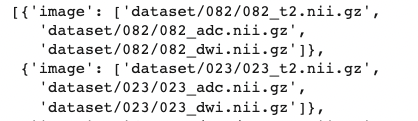

Please also keep in mind that the loading method used here needs relative paths to the bundle root folder to work properly, not absolute paths.

During inference, writing to disk of the model ouputs only takes into account the file name, so please make sure your input nifti samples have different naming, even across modalities of the same sample, convention used here is caseID_modality.nii.gz

The pipeline below showcases :

input_nifti_data_paths 

**-->** 

```
[[caseID1_t2.nii.gz, caseID1_adc.nii.gz, caseID1_dwi.nii.gz],

[caseID2_t2.nii.gz, caseID2_adc.nii.gz, caseID2_dwi.nii.gz],...]
```

**-->** dump to json : datalist.json


This datalist.json is later loaded in the inference.json and looks like this :



```
{"testing" : [relative_path/caseID1_t2.nii.gz, relative_path/caseID1_adc.nii.gz, relative_pathcaseID1_dwi.nii.gz],

[relative_path/caseID2_t2.nii.gz, relative_path/caseID2_adc.nii.gz, relative_path/caseID2_dwi.nii.gz],...}
```




Move QIN-PROST-REP data to monai workspaces folder

In [47]:
!cp /content/prostate158_images/* {os.environ['monai_workspace_dataset']}/

In [48]:
eval_lst = list(zip(sorted(glob.glob(os.path.join(os.environ['monai_workspace_dataset'], "*0000.nii.gz"))), 
         sorted(glob.glob(os.path.join(os.environ['monai_workspace_dataset'], "*0001.nii.gz"))),
         sorted(glob.glob(os.path.join(os.environ['monai_workspace_dataset'], "*0002.nii.gz")))))

input_gt_lst = sorted(glob.glob(os.path.join("/content/prostate158_labels", "*.nii.gz")))

for x in eval_lst : 
    assert os.path.exists(x[0])
    assert os.path.exists(x[1])
    assert os.path.exists(x[2]) 
for x in input_gt_lst : assert os.path.exists(x)
#change absolute path to relative to monai workspace paths for input images
eval_lst = [(os.path.join("dataset", x[0].split("/")[-1]),
             os.path.join("dataset", x[1].split("/")[-1]),
             os.path.join("dataset", x[2].split("/")[-1])) for x in eval_lst]

#select one sample only 
eval_lst = [eval_lst[0]]
input_gt_lst = [input_gt_lst[0]]

In [49]:
!rm -rf {os.path.join(os.environ["monai_workspace"], 'datalist.json')}

In [50]:
for index, item in enumerate(eval_lst) :
  eval_lst[index]={"image" : item}
with open(os.path.join(os.environ["monai_workspace"],'datalist.json'), 'w') as fp:
  json.dump({"testing" : eval_lst}, fp)

Setup of inference.json parameters

In [51]:
inference_json = json.load(open(os.environ["monai_workspace"]+"/configs/inference.json"))
#setup variables
inference_json["bundle_root"] = os.environ["monai_workspace"]
inference_json["output_dir"] = os.environ["monai_workspace_eval"]
inference_json["dataset_dir"] = os.environ["monai_workspace_dataset"]
inference_json["handlers"][0]["load_path"] = os.environ["monai_workspace_model_path"]
inference_json["test_datalist"] = "$monai.data.load_decathlon_datalist('/content/monai_pcdetection_bundle/datalist.json', data_list_key='testing')"

Overriding of inference.json to local workspace

In [52]:
# !rm -rf {os.path.join(os.environ["monai_workspace"],'/configs/inference.json')}
with open(os.environ["monai_workspace"]+'/configs/inference.json', 'w') as fp:
    json.dump(inference_json, fp, indent=4)

# Inference

In [53]:
!python -m monai.bundle run evaluating --meta_file /content/monai_pcdetection_bundle/configs/metadata.json --config_file /content/monai_pcdetection_bundle/configs/inference.json 

2023-05-24 21:53:09,244 - INFO - --- input summary of monai.bundle.scripts.run ---
2023-05-24 21:53:09,244 - INFO - > runner_id: 'evaluating'
2023-05-24 21:53:09,244 - INFO - > meta_file: '/content/monai_pcdetection_bundle/configs/metadata.json'
2023-05-24 21:53:09,244 - INFO - > config_file: '/content/monai_pcdetection_bundle/configs/inference.json'
2023-05-24 21:53:09,244 - INFO - ---


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
2023-05-24 21:53:12,482 - Engine run resuming from iteration 0, epoch 0 until 1 epochs
2023-05-24 21:53:12,687 - Restored all variables from monai_pcdetection_bundle/models/cancer.pt
2023-05-24 21:53:30,190 INFO image_writer.py:194 - writing: monai_pcdetectio

# Evaluation of prostate158 tumors

## DSC Computation

In [ ]:
for pred in glob.glob("/content/monai_pcdetection_bundle/eval/**/*.nii.gz", recursive=True):
  print(pred)
  gt_path = glob.glob(f"/content/prostate158_labels/{'_'.join(pred.split('/')[-1].split('_')[0:2])+'.nii.gz'}")[0]
  print(f"prediction analyzed : {pred}")
  print(f"corresponding ground-truth : {gt_path}")
  print("Dice coefficient/HSDFF/... results")
  !plastimatch dice --dice $gt_path $pred
  print("Done!")
  print('\n')